In [1]:
!pip uninstall tensorflow -y 
!pip install tensorflow==1.15

Found existing installation: tensorflow 2.1.0
Uninstalling tensorflow-2.1.0:
  Successfully uninstalled tensorflow-2.1.0
     |████████████████████████████████| 412.3 MB 22 kB/s s eta 0:00:01     |██████████                      | 127.5 MB 61.4 MB/s eta 0:00:05     |██████████                      | 128.9 MB 61.4 MB/s eta 0:00:05     |██████████▍                     | 133.2 MB 61.4 MB/s eta 0:00:05     |█████████████████████████████   | 374.1 MB 49.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 42.5 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 40.8 MB/s eta 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
You should

In [2]:
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

--2021-09-05 05:17:00--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py’

modeling.py         100%[===================>]  37.03K  --.-KB/s    in 0.001s  

2021-09-05 05:17:00 (26.2 MB/s) - ‘modeling.py’ saved [37922/37922]

--2021-09-05 05:17:00--  https://raw.githubusercontent.com/google-research/bert/master/optimization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6258 (6.1K) [text/plain]
Saving to: ‘

In [3]:
import numpy as np # linear algebra
import re, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf

import datetime
from datetime import datetime

# BERT
import optimization
import run_classifier
import tokenization
import tensorflow_hub as hub

In [4]:
# Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = '../input/bbc-full-text-document-classification/bbc-fulltext (document classification)/bbc/' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)


In [5]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df.head()

,text,label
0,Gordon Brown will seek to put the economy at...,politics
1,Military chiefs are expected to meet to make...,politics
2,Michael Howard has denied his shadow cabinet...,politics
3,Ministers will invite international observer...,politics
4,Ex-chat show host Robert Kilroy-Silk is to c...,politics


In [6]:
df.shape

(2225, 2)

In [7]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
for label in np.unique(df['label']):
    print(label)

business
entertainment
politics
sport
tech


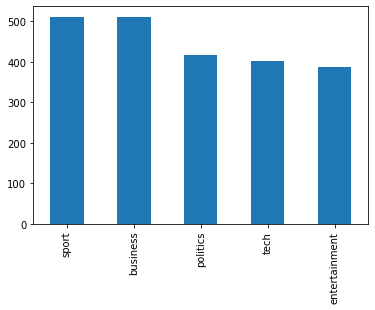

In [9]:
# Checking number of records of each label
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [10]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,text,label
0,Gordon Brown will seek to put the economy at...,2
1,Military chiefs are expected to meet to make...,2
2,Michael Howard has denied his shadow cabinet...,2
3,Ministers will invite international observer...,2
4,Ex-chat show host Robert Kilroy-Silk is to c...,2


In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [12]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.head()

,text,label
0,gordon brown seek put economy centre labours b...,2
1,military chiefs expected meet make final decis...,2
2,michael howard denied shadow cabinet split dec...,2
3,ministers invite international observers check...,2
4,exchat show host robert kilroysilk contest der...,2


In [13]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total

In [14]:
df['text_split'] = df['text'].apply(get_split)
df.head()

,text,label,text_split
0,gordon brown seek put economy centre labours b...,2,[gordon brown seek put economy centre labours ...
1,military chiefs expected meet make final decis...,2,[military chiefs expected meet make final deci...
2,michael howard denied shadow cabinet split dec...,2,[michael howard denied shadow cabinet split de...
3,ministers invite international observers check...,2,[ministers invite international observers chec...
4,exchat show host robert kilroysilk contest der...,2,[exchat show host robert kilroysilk contest de...


In [15]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
    try:
        tf.gfile.DeleteRecursively(OUTPUT_DIR)
#         tf.compat.v1.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


In [16]:
train, val = train_test_split(df, test_size=0.2, random_state=35)
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label,text_split
0,fox hunting dogs illegal england wales ban act...,2,[fox hunting dogs illegal england wales ban ac...
1,top seeds south africa return scene one embarr...,3,[top seeds south africa return scene one embar...


In [17]:
# Get labels
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4]

In [18]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label,text_split
0,listen full interview sport five bbc sport web...,3,[listen full interview sport five bbc sport we...
1,ronan ogara scored irelands points home side c...,3,[ronan ogara scored irelands points home side ...


In [19]:
val.shape, train.shape

((445, 3), (1780, 3))

In [20]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(2176, 2176, 2176)

In [21]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(538, 538, 538)

In [22]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,fox hunting dogs illegal england wales ban act...,2
1,top seeds south africa return scene one embarr...,3
2,teenagers able become mps plans unveiled minis...,2
3,price gold fallen international monetary fund ...,0
4,manchester united reduced chelseas premiership...,3


In [23]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,listen full interview sport five bbc sport web...,3
1,season parry said sincerely hope steven knows ...,3
2,complete naming rights given anfield club seri...,3
3,discussions steve course think came close conc...,3
4,ronan ogara scored irelands points home side c...,3


In [24]:
# X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.20, random_state=42)

In [25]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [26]:
train_InputExamples


0       <run_classifier.InputExample object at 0x7f9ac...
1       <run_classifier.InputExample object at 0x7f9ac...
2       <run_classifier.InputExample object at 0x7f9ac...
3       <run_classifier.InputExample object at 0x7f9ac...
4       <run_classifier.InputExample object at 0x7f9ac...
                              ...                        
1775    <run_classifier.InputExample object at 0x7f9ac...
1776    <run_classifier.InputExample object at 0x7f9ac...
1777    <run_classifier.InputExample object at 0x7f9ac...
1778    <run_classifier.InputExample object at 0x7f9ac...
1779    <run_classifier.InputExample object at 0x7f9ac...
Length: 1780, dtype: object

In [27]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  fox hunting dogs illegal england wales ban activity came force overnight law faces stiff test weekend countryside alliance saying many hunts force chief police officers spokesman nigel yeo said expected people would obey law drag hunting chasing foxes shooting said police would challenge one two isolated hunts threatening break law simon hart countryside alliance questioned police ensure violations definitions legal illegal hunting blurred police asked make impossible judgements hunt rat mouse rabbit hare artificial scent real one said attorney general lord goldsmith far issued instructions police deal hunters violate law said consult director public prosecutions police near future decide measures take regards hunting prosecutions rejected blanket policy enforcing ban house lords considered legality john cooper barrister chairman league cruel sports said antihunting lobby expects authorities prosecute wh

In [28]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
#     with tf.compat.v1.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

In [29]:
len(tokenizer.vocab.keys())

30522

In [30]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['fox', 'hunting', 'dogs', 'illegal', 'england', 'wales', 'ban', 'activity', 'came', 'force', 'overnight', 'law', 'faces', 'stiff', 'test', 'weekend', 'countryside', 'alliance', 'saying', 'many', 'hunts', 'force', 'chief', 'police', 'officers', 'spokesman', 'nigel', 'ye', '##o', 'said', 'expected', 'people', 'would', 'obey', 'law', 'drag', 'hunting', 'chasing', 'foxes', 'shooting', 'said', 'police', 'would', 'challenge', 'one', 'two', 'isolated', 'hunts', 'threatening', 'break', 'law', 'simon', 'hart', 'countryside', 'alliance', 'questioned', 'police', 'ensure', 'violations', 'definitions', 'legal', 'illegal', 'hunting', 'blurred', 'police', 'asked', 'make', 'impossible', 'judgement', '##s', 'hunt', 'rat', 'mouse', 'rabbit', 'hare', 'artificial', 'scent', 'real', 'one', 'said', 'attorney', 'general', 'lord', 'goldsmith', 'far', 'issued', 'instructions', 'police', 'deal', 'hunters', 'violate', 'law', 'said', 'consult', 'director', 'public', 'prosecution', '##s', 'police', 'near', 'futur

#### 2. Converting the train and validation features to InputFeatures that BERT understands.

In [31]:
MAX_SEQ_LENGTH = 200

train_features = run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [32]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  fox hunting dogs illegal england wales ban activity came force overnight law faces stiff test weekend countryside alliance saying many hunts force chief police officers spokesman nigel yeo said expected people would obey law drag hunting chasing foxes shooting said police would challenge one two isolated hunts threatening break law simon hart countryside alliance questioned police ensure violations definitions legal illegal hunting blurred police asked make impossible judgements hunt rat mouse rabbit hare artificial scent real one said attorney general lord goldsmith far issued instructions police deal hunters violate law said consult director public prosecutions police near future decide measures take regards hunting prosecutions rejected blanket policy enforcing ban house lords considered legality john cooper barrister chairman league cruel sports said antihunting lobby expects authorities prosecute wherever clear evidence illegal hunting practices said police acknowledge

### Creating prediction model

In [33]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
    bert_module = hub.Module(
        BERT_MODEL_HUB,
        trainable=True)
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]
    # with tf.Session() as sess:
    output_layer1 = bert_outputs["pooled_output"]
    # output_layer1 = 999
    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs, output_layer1)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return (loss, predicted_labels, log_probs)

In [34]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(
                    label_ids,
                    predicted_labels)
                true_neg = tf.metrics.true_negatives(
                    label_ids,
                    predicted_labels)   
                false_pos = tf.metrics.false_positives(
                    label_ids,
                    predicted_labels)  
                false_neg = tf.metrics.false_negatives(
                    label_ids,
                    predicted_labels)

                return {
                    "eval_accuracy": accuracy,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg,
                    }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                  loss=loss,
                  train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs, output_layer) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels,
              'pooled_output': output_layer
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

In [35]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [36]:
num_train_steps, len(label_list)


(111, 5)

### Initializing the model and the estimator


In [37]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

In [38]:
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

### Training the model

In [39]:
# Training
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training took time  0:40:30.062520


### Validation

In [40]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'eval_accuracy': 0.9730337,
 'false_negatives': 3.0,
 'false_positives': 5.0,
 'loss': 0.124107406,
 'true_negatives': 103.0,
 'true_positives': 334.0,
 'global_step': 111}